In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from pandas_profiling import ProfileReport
from keplergl import KeplerGl

print("Pandas Version: " + pd.__version__)
print("Numpy Version: " + np.__version__)
print("Seaborn Version: " + sns.__version__)

Pandas Version: 1.2.0
Numpy Version: 1.18.5
Seaborn Version: 0.11.1


In [2]:
trips = pd.read_csv("../data/clean/trips.csv", parse_dates=["date_from", "date_until"])
trips.sample(3)

,bike_id,user_id,date_from,date_until,start_station_name,start_station_id,end_station_name,end_station_id,booked_via,duration_in_min,distance_in_km,speed_in_kmh
591124,143714,B55EAA7F8955CCAD682113B51B67B7496B671CC7,2014-05-07 13:40:27,2014-05-07 13:50:48,Landwehr / Ramazan-Avci-Platz,140802,Burgstraße/Hammer Landstraße,131639,Terminal HH_76 (-2313-),11,0.666064,3.633076
6682279,143540,6E0D11D3BF7F46741FF948EC669F2E5C16AD15DE,2016-12-06 07:41:51,2016-12-06 07:52:18,Fuhlsbüttler Straße/Hartzloh,245204,Wiesendamm/Roggenkamp,212607,iPhone SRH,11,1.568400,8.554907
6468542,110598,6ACB891583D56BD62D74010DA376D0844ABD6D80,2016-10-28 17:02:05,2016-10-28 17:26:20,Troplowitzstraße / Beiersdorf / NXP,233536,Isestraße / Hoheluftbrücke,140804,iPhone SRH,25,1.404485,3.370764


In [37]:
stations = pd.read_csv("../data/clean/stations.csv")
stations.sample(3)

,station_id,name,longitude,latitude
191,253357,Djarkartaweg/Sengelmannstraße,10.022685,53.609163
41,138376,Jarrestraße / Rambatzweg,10.021100,53.584000
171,250340,Hugo-Kirchberg-Straße/Tesa,9.985280,53.654290


In [52]:
start_count = trips.value_counts(subset=["start_station_id"]).to_frame()
start_count.rename(columns={0: "check_outs"}, inplace=True)

end_count = trips.value_counts(subset=["end_station_id"]).to_frame()
end_count.rename(columns={0: "check_ins"}, inplace=True)

stations_count = stations.merge(start_count, left_on="station_id", right_index=True, sort=False)
stations_count = stations_count.merge(end_count, left_on="station_id", right_index=True, sort=False)
stations_count["diff"] = stations_count.apply(lambda x: x["check_ins"] - x["check_outs"], axis=1)

stations_count.sort_values(by="diff")

,station_id,name,longitude,latitude,check_outs,check_ins,diff
19,131872,Hauptbahnhof West / Glockengießer Wall,10.004553,53.553676,94646,80907,-13739
20,131873,Hauptbahnhof Ost / Hachmannplatz,10.007652,53.554307,96983,86420,-10563
32,131889,Bahnhof Altona West / Busbahnhof,9.933870,53.551800,70642,62699,-7943
108,213679,U-Bahn Schlump,9.969601,53.567991,68568,62426,-6142
16,131652,Berliner Tor / Berlinertordamm,10.024600,53.553300,79654,73947,-5707
...,...,...,...,...,...,...,...
119,218173,Rothenburgsort/Marktplatz/Lindleystraße,10.038938,53.534288,20569,25532,4963
23,131879,Jungfernstieg / Ballindamm,9.995501,53.552244,107754,113539,5785
0,131543,Landungsbrücke/Hafentor,9.972300,53.545700,89663,95542,5879
78,199402,Mannesallee/Veringstraße,9.987298,53.514265,20701,27388,6687


In [67]:
foo = stations_count.sort_values(by="diff")[["name", "diff"]]
foo

,name,diff
19,Hauptbahnhof West / Glockengießer Wall,-13739
20,Hauptbahnhof Ost / Hachmannplatz,-10563
32,Bahnhof Altona West / Busbahnhof,-7943
108,U-Bahn Schlump,-6142
16,Berliner Tor / Berlinertordamm,-5707
...,...,...
119,Rothenburgsort/Marktplatz/Lindleystraße,4963
23,Jungfernstieg / Ballindamm,5785
0,Landungsbrücke/Hafentor,5879
78,Mannesallee/Veringstraße,6687


<AxesSubplot:xlabel='diff', ylabel='name'>

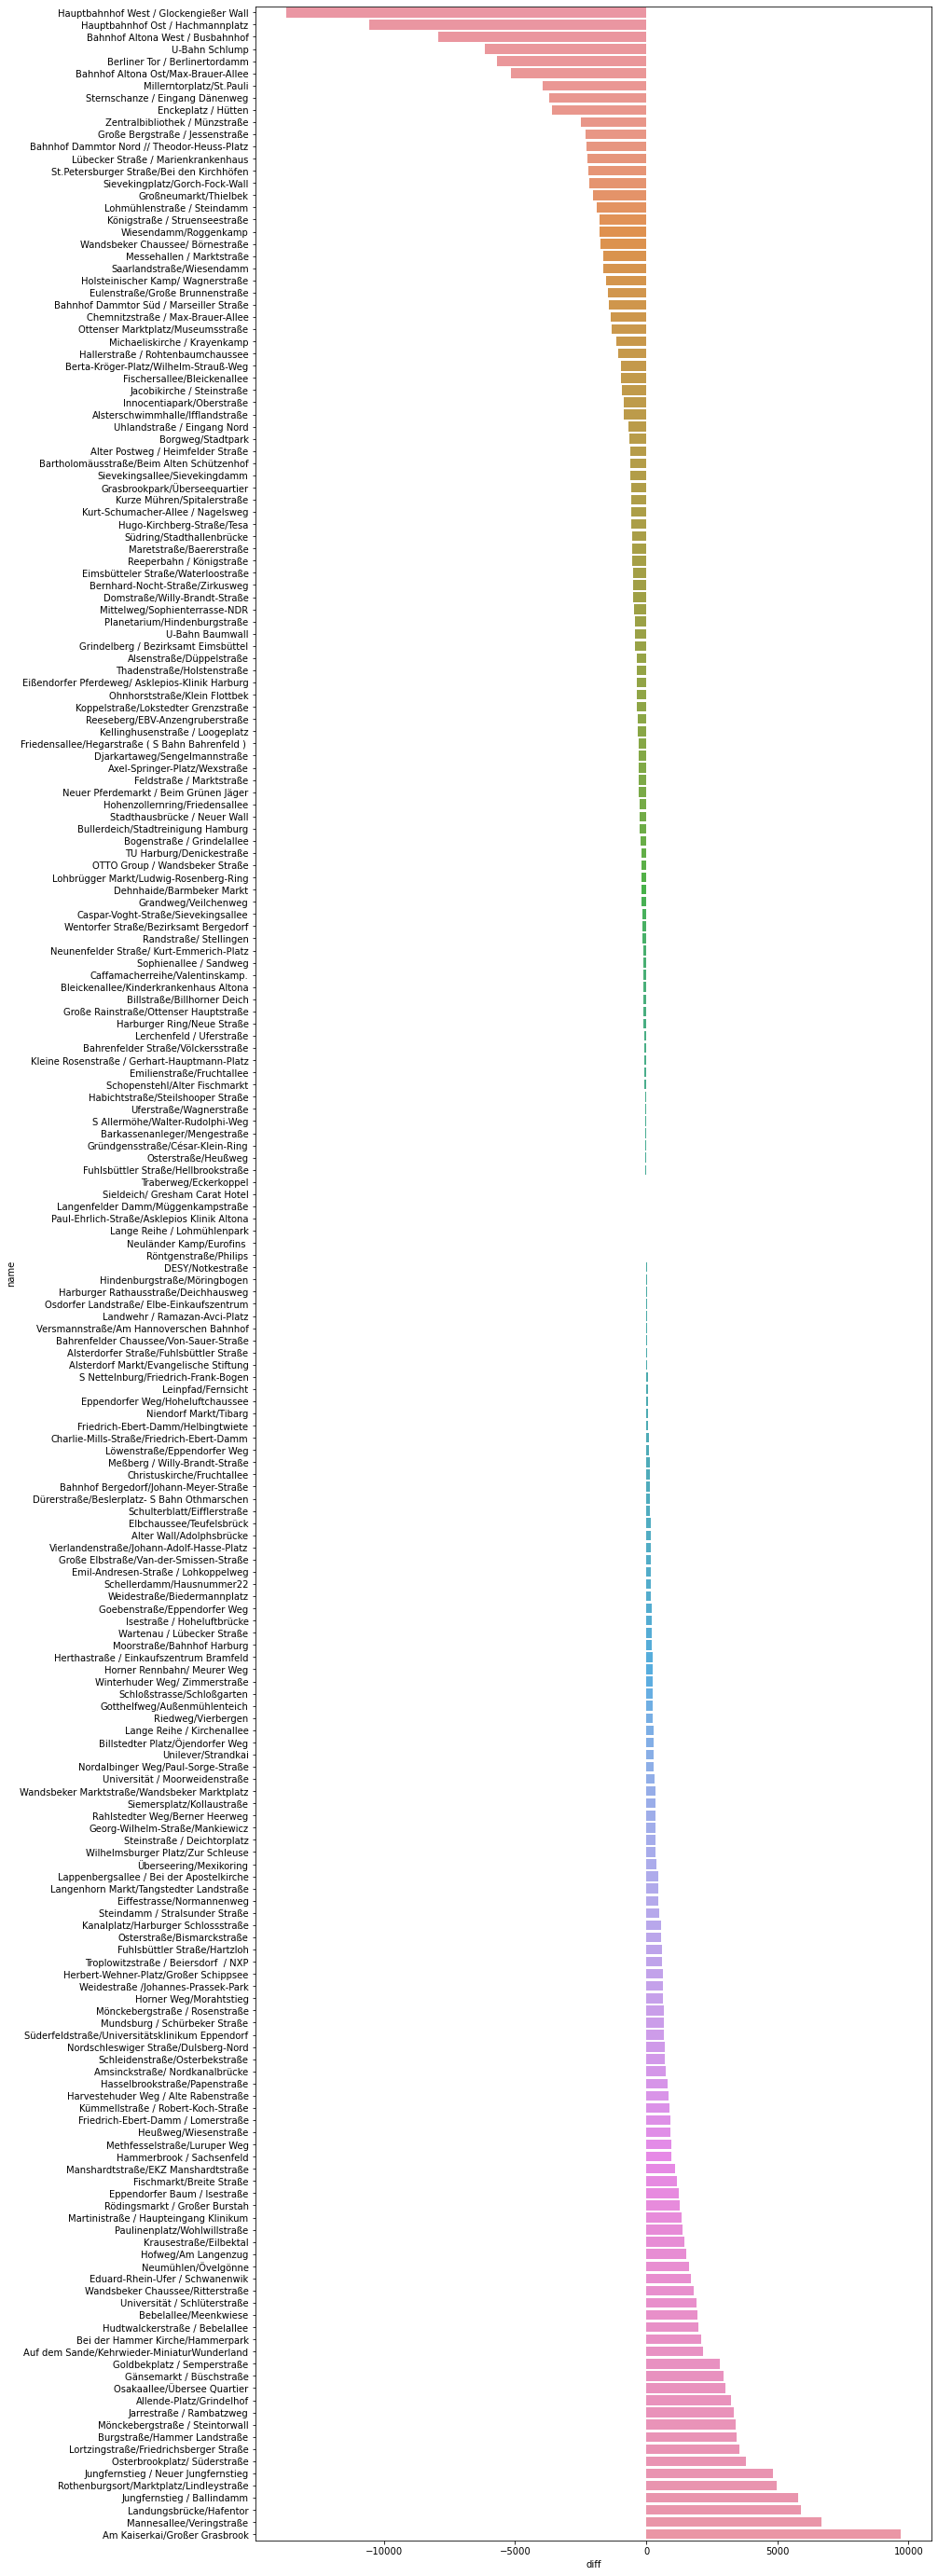

In [68]:
plt.figure(figsize=(13,50))
sns.barplot(data=foo, x="diff", y="name")

In [18]:
# Count occurrence of each pair (not symmetrically)
pair_count = trips.value_counts(subset=["start_station_name", "end_station_name"], sort=True).to_frame()
pair_count.reset_index(inplace=True)

# Rename column
pair_count.rename(columns={0: "count"}, inplace=True)

# Aggregate symmetrically
sorted_pairs = np.sort(pair_count[["start_station_name", "end_station_name"]], axis=1)
pair_count = pair_count.groupby([sorted_pairs[:,0], sorted_pairs[:,1]])["count"].sum().reset_index()

# Rename columns
pair_count.rename(columns={"level_0": "station_x", "level_1": "station_y"}, inplace=True)
pair_count

,station_x,station_y,count
0,Allende-Platz/Grindelhof,Allende-Platz/Grindelhof,4112
1,Allende-Platz/Grindelhof,Alsenstraße/Düppelstraße,3273
2,Allende-Platz/Grindelhof,Alsterdorf Markt/Evangelische Stiftung,34
3,Allende-Platz/Grindelhof,Alsterdorfer Straße/Fuhlsbüttler Straße,6
4,Allende-Platz/Grindelhof,Alsterschwimmhalle/Ifflandstraße,647
...,...,...,...
13640,Winterhuder Weg/ Zimmerstraße,Zentralbibliothek / Münzstraße,249
13641,Winterhuder Weg/ Zimmerstraße,Überseering/Mexikoring,377
13642,Zentralbibliothek / Münzstraße,Zentralbibliothek / Münzstraße,789
13643,Zentralbibliothek / Münzstraße,Überseering/Mexikoring,4


In [19]:
# Add coordinates to station pairs

pairs = pd.merge(pair_count, stations, left_on="station_x", right_on="name", how="left", sort=False)
pairs.rename(
    columns={
        "latitude": "latitude_x", 
        "longitude": "longitude_x",
    }, 
    inplace=True
)

pairs = pd.merge(pairs, stations, left_on="station_y", right_on="name", how="left", sort=False)
pairs.rename(
    columns={
        "latitude": "latitude_y", 
        "longitude": "longitude_y",
    }, 
    inplace=True
)

pairs.drop(columns=["station_id_x", "name_x", "station_id_y", "name_y"], inplace=True)
pairs

,station_x,station_y,count,longitude_x,latitude_x,longitude_y,latitude_y
0,Allende-Platz/Grindelhof,Allende-Platz/Grindelhof,4112,9.982728,53.567845,9.982728,53.567845
1,Allende-Platz/Grindelhof,Alsenstraße/Düppelstraße,3273,9.982728,53.567845,9.948345,53.563037
2,Allende-Platz/Grindelhof,Alsterdorf Markt/Evangelische Stiftung,34,9.982728,53.567845,10.023946,53.612091
3,Allende-Platz/Grindelhof,Alsterdorfer Straße/Fuhlsbüttler Straße,6,9.982728,53.567845,10.032000,53.620000
4,Allende-Platz/Grindelhof,Alsterschwimmhalle/Ifflandstraße,647,9.982728,53.567845,10.022148,53.560781
...,...,...,...,...,...,...,...
13640,Winterhuder Weg/ Zimmerstraße,Zentralbibliothek / Münzstraße,249,10.020450,53.575308,10.008849,53.550332
13641,Winterhuder Weg/ Zimmerstraße,Überseering/Mexikoring,377,10.020450,53.575308,10.024745,53.601619
13642,Zentralbibliothek / Münzstraße,Zentralbibliothek / Münzstraße,789,10.008849,53.550332,10.008849,53.550332
13643,Zentralbibliothek / Münzstraße,Überseering/Mexikoring,4,10.008849,53.550332,10.024745,53.601619


In [20]:
sorted_pairs = pairs.sort_values(by="count", ascending=False).reset_index()
sorted_pairs.drop(columns="index", inplace=True)
sorted_pairs

,station_x,station_y,count,longitude_x,latitude_x,longitude_y,latitude_y
0,Bahnhof Altona West / Busbahnhof,Bahrenfelder Straße/Völckersstraße,35315,9.933870,53.551800,9.927945,53.556897
1,Saarlandstraße/Wiesendamm,Schleidenstraße/Osterbekstraße,28563,10.032680,53.588735,10.033690,53.584582
2,Mundsburg / Schürbeker Straße,Winterhuder Weg/ Zimmerstraße,22710,10.027100,53.569600,10.020450,53.575308
3,Am Kaiserkai/Großer Grasbrook,U-Bahn Baumwall,21496,9.992856,53.541838,9.980896,53.544279
4,Krausestraße/Eilbektal,Lortzingstraße/Friedrichsberger Straße,21366,10.058237,53.576238,10.049568,53.573588
...,...,...,...,...,...,...,...
13640,Rothenburgsort/Marktplatz/Lindleystraße,Troplowitzstraße / Beiersdorf / NXP,1,10.038938,53.534288,9.957594,53.582793
13641,Bahrenfelder Chaussee/Von-Sauer-Straße,Winterhuder Weg/ Zimmerstraße,1,9.910870,53.565973,10.020450,53.575308
13642,Rothenburgsort/Marktplatz/Lindleystraße,Südring/Stadthallenbrücke,1,10.038938,53.534288,10.030327,53.591446
13643,Große Rainstraße/Ottenser Hauptstraße,Planetarium/Hindenburgstraße,1,9.930344,53.552339,10.013650,53.595950


In [21]:
sorted_pairs.describe()

,count,longitude_x,latitude_x,longitude_y,latitude_y
count,13645.000000,13645.000000,13645.000000,13645.000000,13645.000000
mean,557.418688,9.994009,53.564077,9.998526,53.564850
std,1312.619420,0.043241,0.022581,0.041571,0.022582
min,1.000000,9.862013,53.447625,9.862013,53.447625
25%,24.000000,9.965669,53.551600,9.970330,53.551000
50%,132.000000,9.991400,53.560200,9.997140,53.563755
75%,530.000000,10.022685,53.577579,10.027100,53.580004
max,35315.000000,10.220000,53.654290,10.220000,53.654290


In [22]:
top_pairs = sorted_pairs[sorted_pairs["count"] >= sorted_pairs["count"].quantile(0.9)]

In [23]:
top_pairs.describe()

,count,longitude_x,latitude_x,longitude_y,latitude_y
count,1367.000000,1367.000000,1367.000000,1367.000000,1367.000000
mean,3329.213606,9.991065,53.561967,9.991554,53.561969
std,2771.709042,0.033146,0.020678,0.032524,0.020839
min,1463.000000,9.862013,53.447625,9.887159,53.447625
25%,1829.000000,9.969214,53.552244,9.969250,53.552244
50%,2445.000000,9.989710,53.561109,9.987659,53.562709
75%,3729.500000,10.014402,53.575491,10.014900,53.575308
max,35315.000000,10.206105,53.654290,10.220000,53.648757


In [24]:
top_pairs.head(10)

,station_x,station_y,count,longitude_x,latitude_x,longitude_y,latitude_y
0,Bahnhof Altona West / Busbahnhof,Bahrenfelder Straße/Völckersstraße,35315,9.933870,53.551800,9.927945,53.556897
1,Saarlandstraße/Wiesendamm,Schleidenstraße/Osterbekstraße,28563,10.032680,53.588735,10.033690,53.584582
2,Mundsburg / Schürbeker Straße,Winterhuder Weg/ Zimmerstraße,22710,10.027100,53.569600,10.020450,53.575308
3,Am Kaiserkai/Großer Grasbrook,U-Bahn Baumwall,21496,9.992856,53.541838,9.980896,53.544279
4,Krausestraße/Eilbektal,Lortzingstraße/Friedrichsberger Straße,21366,10.058237,53.576238,10.049568,53.573588
5,Am Kaiserkai/Großer Grasbrook,Landungsbrücke/Hafentor,20317,9.992856,53.541838,9.972300,53.545700
6,Hallerstraße / Rohtenbaumchaussee,Universität / Schlüterstraße,19767,9.988801,53.572081,9.986076,53.566972
7,Eppendorfer Baum / Isestraße,Martinistraße / Haupteingang Klinikum,19511,9.984410,53.583200,9.975715,53.588918
8,Kellinghusenstraße / Loogeplatz,Martinistraße / Haupteingang Klinikum,18974,9.991125,53.588516,9.975715,53.588918
9,Jarrestraße / Rambatzweg,Mundsburg / Schürbeker Straße,18640,10.021100,53.584000,10.027100,53.569600


In [25]:
config = eval(open("calculations/map_config_most_popular.py", "r").read())
map = KeplerGl(height=700, data={"data": top_pairs, "stations": stations}, config=config)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'mz5vtjc', 'type': …

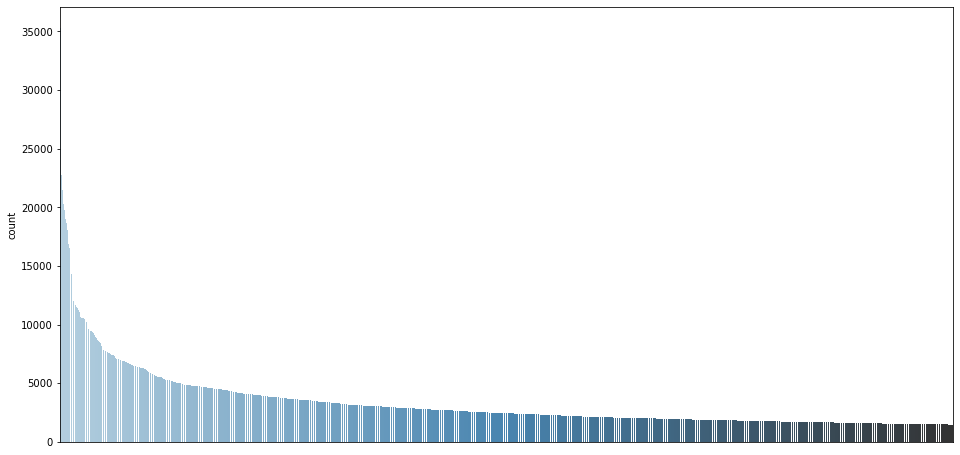

In [100]:
plt.figure(figsize=(16, 8))
ax = sns.barplot(y="count", x=top_pairs.index, data=top_pairs, palette="Blues_d")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.savefig("figures/stations_top_dist.png", bbox_inches="tight")
plt.show()